In [246]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [247]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

## tolgo record con outliers -> non va perchè dovrei cambiare i bin

In [ ]:
# pp_class = pp_class[pp_class['outlier']!=True]
# pp_test_class = pp_test_class[pp_test_class['outlier']!=True]

### Preprocessing delle variabili

Elimino righe videogame

In [249]:
pp_class = pp_class[pp_class['titleType'] != 'videoGame']
pp_class[['originalTitle', 'titleType']].head(15)

pp_test_class = pp_test_class[pp_test_class['titleType'] != 'videoGame']

Mapping variabile target

In [250]:

y = np.array(pp_class['titleType'])  # Il target originale


# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

y_map # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'video': 3,
 'tvMiniSeries': 4,
 'short': 5,
 'tvMovie': 6,
 'tvSpecial': 7,
 'tvShort': 8}

##### info variabili

In [251]:
# pp_class = pp_class[pp_class['titleType'] == 'tvSeries']
# pp_class_tvs = pp_class[(pp_class['titleType'] == 'tvSeries') & (pp_class['runtimeMinutes'] > 90.0)]

# pp_class[['originalTitle', 'rating', 'startYear', 'endYear','titleType', "runtimeMinutes" ]].head(40)

In [252]:
# pp_class_tvs.count()

In [253]:
# #studio variabili (non ho messo le 28 is_genere)
# pp_class[['originalTitle', 'rating', 'startYear', 'endYear', 
#           #'runtimeMinutes','awardWins', 
#         'numVotes', 
#         #'totalImages', 'totalVideos', 
#         'totalCredits',
#        'criticReviewsTotal', 'titleType', 
#        #'awardNominationsExcludeWins',
#        'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
#        #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller','is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography','is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult','is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short','is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama','is_Sport', 'is_War', 'is_Horror', 'is_Animation',
#        # 'fill_runtimeMinutes', 
#        #'is_from_Oceania', 'is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa','is_from_Europe', 
#        'countryOfOrigin', 'countryOfOrigin_freq_enc',
#        'countryOfOrigin_NA', 
#       # 'countryOfOrigin_AF', 'countryOfOrigin_AS','countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA', 'countryOfOrigin_UNK', ''
#        'fill_runtimeMinutes_Bruno', 'totalNominations',
#        'totalMedia', 'runtimeMinutes_notitletype', 'titleType_encoded'
#        ]].head(15)

In [254]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1 (is Adult già binaria)

In [255]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [256]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> tolto finchè non capiamo come gestirlo -> ora commentato nella scelta features

In [257]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE SE GIà SOSTITUITO

#OPPURE RIMUOVI
#pp_class= pp_class.drop(["endYear"], axis=1)
##pp_test_class= pp_class.drop(["endYear"], axis=1)

#### tolgo  RUNTIME MINUTES IMPUTED-> ha nan

In [258]:
pp_class= pp_class.drop(["runtimeMinutes_imputed"], axis=1)
pp_test_class= pp_test_class.drop(["runtimeMinutes_imputed"], axis=1)


BINARIZZAZIONE -> TOTALmEDIA E TOTALnOM

In [259]:

#1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)


In [260]:
#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

bins = [-1, 0, 2, 10, pp_test_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_class['media_bin'] = pd.cut(pp_class['totalMedia'], bins=bins, labels=labels)


bins = [-1, 0, 1, 8, 50, pp_test_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_test_class['media_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins, labels=labels)


In [261]:
# Calcola statistiche descrittive per la colonna 'runtimeMinutes_notitletype' di pp_test

# Se vuoi anche per il train:
print("\nStatistiche runtimeMinutes_notitletype (train):")
print(pp_class['runtimeMinutes_notitletype'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))


Statistiche runtimeMinutes_notitletype (train):
count    16172.000000
mean        60.610129
std         46.154686
min          0.000000
25%         30.000000
50%         60.000000
75%         88.000000
90%        100.000000
95%        115.000000
99%        166.000000
max       3000.000000
Name: runtimeMinutes_notitletype, dtype: float64


In [262]:
#train

#FILL_RUNTIMEMINS_BRUNO 
bins = [ -1, 30, 60, 88, 115, float('inf') ]
labels = ['VeryLowRuntime', 'LowRuntime', 'MediumRuntime', 'HighRuntime', "VeryHighRuntime"]
pp_class['runtime_bin'] = pd.cut(pp_class['runtimeMinutes_notitletype'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_class['rating'].max()]
labels = ['VeryLowRating', 'LowRating', 'MediumRating', 'HighRating', "VeryHighRating"]
pp_class['rating_bin'] = pd.cut(pp_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['VeryLowVotes', 'LowVotes', 'MediumVotes', 'HighVotes', 'VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_class['numVotes_bin'] = pd.cut(pp_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1878,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_class['startYear'].max()] #era corrente
labels = ['pre-1930', '1930-1954', '1955-1979', '1980-1999', '2000-2019', 'post-2020']
pp_class['startYear_bin'] = pd.cut(pp_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['VeryLowCredits', 'LowCredits', 'MediumCredits', 'HighCredits', 'VeryHighCredits']
bins = [-1, 15, 35, 65, 200, float('inf')]
pp_class['totalCredits_bin'] = pd.cut(pp_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    'NoCriticReviews',
    'FewCriticReviews',
    'ModerateCriticReviews',
    'ManyCriticReviews',
    'VeryHighCriticReviews',
    'ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_class['criticReviewsTotal_bin'] = pd.cut(pp_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['VeryFewRegions', 'ModerateRegions', 'ManyRegions', 'GlobalRegions']
bins = [0, 1, 3, 8, float('inf')]
pp_class['numRegions_bin'] = pd.cut(pp_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['NoUserReviews', 'FewUserReviews', 'ManyUserReviews', 'VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]
pp_class['userReviewsTotal_bin'] = pd.cut(pp_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN freq-> CANCELLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['LowFreqCountries', 'MediumFreqCountries', 'HighFreqCountries']
pp_class["country_freq_bin"] = pd.cut( pp_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> CANCELLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_class, "countryOfOrigin_UNK", "from_Unknown")


In [263]:
#test

#FILL_RUNTIMEMINS_BRUNO 
bins = [-1, 25, 60, 120, 180, pp_test_class['runtimeMinutes_notitletype'].max()]
labels = ['VeryLowRuntime', 'LowRuntime', 'MediumRuntime', 'HighRuntime', "VeryHighRuntime"]
pp_test_class['runtime_bin'] = pd.cut(pp_test_class['runtimeMinutes_notitletype'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_test_class['rating'].max()]
labels = ['VeryLowRating', 'LowRating', 'MediumRating', 'HighRating', "VeryHighRating"]
pp_test_class['rating_bin'] = pd.cut(pp_test_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['VeryLowVotes', 'LowVotes', 'MediumVotes', 'HighVotes', 'VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_test_class['numVotes_bin'] = pd.cut(pp_test_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1877,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_test_class['startYear'].max()] #era corrente
labels = ['pre-1930', '1930-1954', '1955-1979', '1980-1999', '2000-2019', 'post-2020']
pp_test_class['startYear_bin'] = pd.cut(pp_test_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['VeryLowCredits', 'LowCredits', 'MediumCredits', 'HighCredits', 'VeryHighCredits']
bins = [-1, 15, 35, 65, 200, float('inf')]

pp_test_class['totalCredits_bin'] = pd.cut(pp_test_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    'NoCriticReviews',
    'FewCriticReviews',
    'ModerateCriticReviews',
    'ManyCriticReviews',
    'VeryHighCriticReviews',
    'ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_test_class['criticReviewsTotal_bin'] = pd.cut(pp_test_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['VeryFewRegions', 'ModerateRegions', 'ManyRegions', 'GlobalRegions']
bins = [0, 1, 3, 8, float('inf')]
pp_test_class['numRegions_bin'] = pd.cut(pp_test_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['NoUserReviews', 'FewUserReviews', 'ManyUserReviews', 'VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]

pp_test_class['userReviewsTotal_bin'] = pd.cut(pp_test_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN FREQ ENC -> CANCELLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['LowFreqCountries', 'MediumFreqCountries', 'HighFreqCountries']

pp_test_class["country_freq_bin"] = pd.cut( pp_test_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> CANCELLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_test_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_test_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_test_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_test_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_test_class, "countryOfOrigin_UNK", "from_Unknown")


### !! DIVERSO DA GAIA (1,5,6,9)--> Filtra dataset su classi meno rappresentate ->"tvMovie": 7, "tvSpecial":8, "tvShort":9

In [264]:
#pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])] # isin([1,5,6,9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

Encoding di titletype per multiclass classification task

In [265]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

####  creazione array di valori -> da cui scegliere feature da usare

In [266]:
X_train = pp_class[[
       'rating_bin',
       'startYear_bin', 
       'totalCredits_bin',
       'criticReviewsTotal_bin', 
       'canHaveEpisodes', 
       'userReviewsTotal_bin',  
       'country_freq_bin', ########  forsecrea problemi
       'from_NorthAmerica_bin', 
       'totalMedia_bin',
       'runtime_bin',
       #'numVotes_bin',
       #'isAdult', #peggiora molto
       #'numRegions_ ', 
       #'from_Europe_bin', 'from_SouthAmerica_bin', 'from_Asia_bin',  'from_Oceania_bin', 'from_Africa_bin', 'from_Unknown_bin',
       #'totalNominations_bin',
 
       ]].values

X_test = pp_test_class[[ 
       'rating_bin',
       'startYear_bin', 
       'totalCredits_bin',
       'criticReviewsTotal_bin', 
       'canHaveEpisodes', 
       'userReviewsTotal_bin',  
       'country_freq_bin', ########  forsecrea problemi
       'from_NorthAmerica_bin', 
       'totalMedia_bin',
       'runtime_bin',
       #'numVotes_bin',
       #'isAdult', #peggiora molto
       #'numRegions_ ', 
       #'from_Europe_bin', 'from_SouthAmerica_bin', 'from_Asia_bin',  'from_Oceania_bin', 'from_Africa_bin', 'from_Unknown_bin',
       #'totalNominations_bin',
 
       ]].values

In [267]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [268]:
X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)

In [269]:
print(X_train2.shape, X_val.shape, X_train.shape
      , X_test.shape
      )

(12937, 10) (3235, 10) (16172, 10) (5384, 10)


In [270]:
# CATEGORICAL
X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## NAIVE BAYES

In [271]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf = CategoricalNB()

In [272]:
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

Predicting on validation set

In [273]:
y_pred = clf.predict(X_val_tr)
y_pred

array([1, 0, 6, ..., 2, 1, 0], dtype=int64)

In [274]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3235
3235


In [275]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6}


In [276]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.7397217928902627

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       955
           1       0.76      0.87      0.81      1098
           2       0.85      0.99      0.92       260
           3       0.42      0.34      0.38       152
           4       0.57      0.08      0.15        48
           5       0.77      0.79      0.78       506
           6       0.33      0.02      0.04       176
           7       0.00      0.00      0.00        32
           8       0.00      0.00      0.00         8

    accuracy                           0.74      3235
   macro avg       0.49      0.43      0.42      3235
weighted avg       0.70      0.74      0.71      3235



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [277]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[2.52860820e-01, 4.88878403e-01, 1.96689408e-04, ...,
        1.82081265e-01, 1.34399484e-02, 6.61514994e-04],
       [4.55851848e-01, 6.09168267e-04, 6.23518198e-05, ...,
        3.33781895e-02, 2.69746612e-03, 3.82035939e-02],
       [1.12711741e-01, 2.77717152e-01, 7.17285752e-06, ...,
        2.91358347e-01, 1.79851167e-02, 2.80990616e-03],
       ...,
       [1.52324843e-04, 5.63107403e-05, 8.08717602e-01, ...,
        2.11658476e-04, 1.32833786e-04, 3.06621781e-05],
       [1.00995019e-02, 8.68210642e-01, 2.63020154e-06, ...,
        1.08674447e-01, 1.58930648e-03, 4.52885933e-04],
       [8.76561419e-01, 7.51463484e-04, 1.47501176e-04, ...,
        5.91087725e-03, 3.85912494e-03, 8.19473257e-04]])

roc test

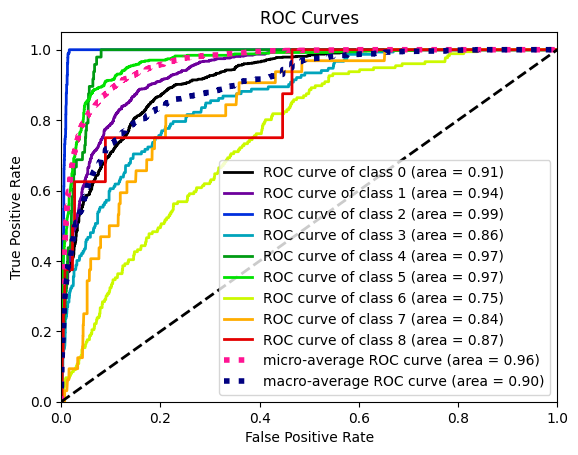

0.901835097668769


In [278]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

verifica overfitting

Performance sul Training set:
Accuracy: 0.7431
F1 Score: 0.7154

Performance sul Validation set:
Accuracy: 0.7397
F1 Score: 0.7093


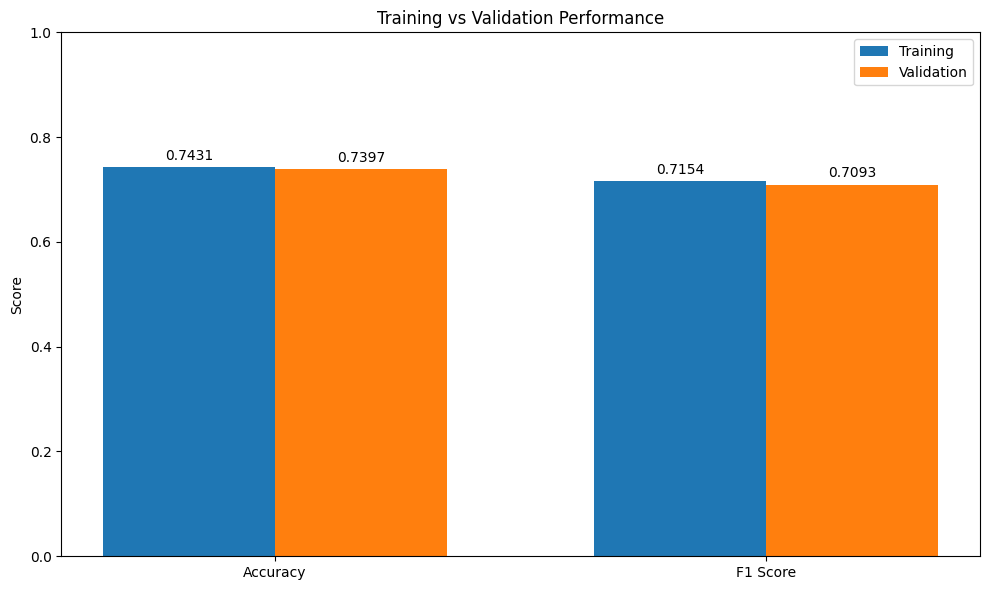

In [279]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Distribuzioni classi nel train set
- classi con < support sono quelle con performance peggiori
- calitare se togliere classi (togliendo 7,8,9 migliora molto)

In [280]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3743
1    4437
2    1115
3     640
4     176
5    1968
6     692
7     134
8      32
Name: count, dtype: int64


confusion matrix 

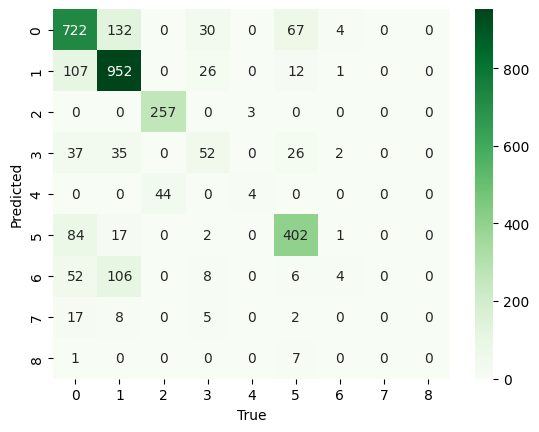

In [281]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Proper testing on the test set

In [282]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred
# era y_tpred

array([5, 1, 0, ..., 1, 2, 2], dtype=int64)

In [283]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_test))  

5384
5384


Performance sul Training set:
Accuracy: 0.7422
F1 Score: 0.7134

Performance sul test set:
Accuracy: 0.7381
F1 Score: 0.7083


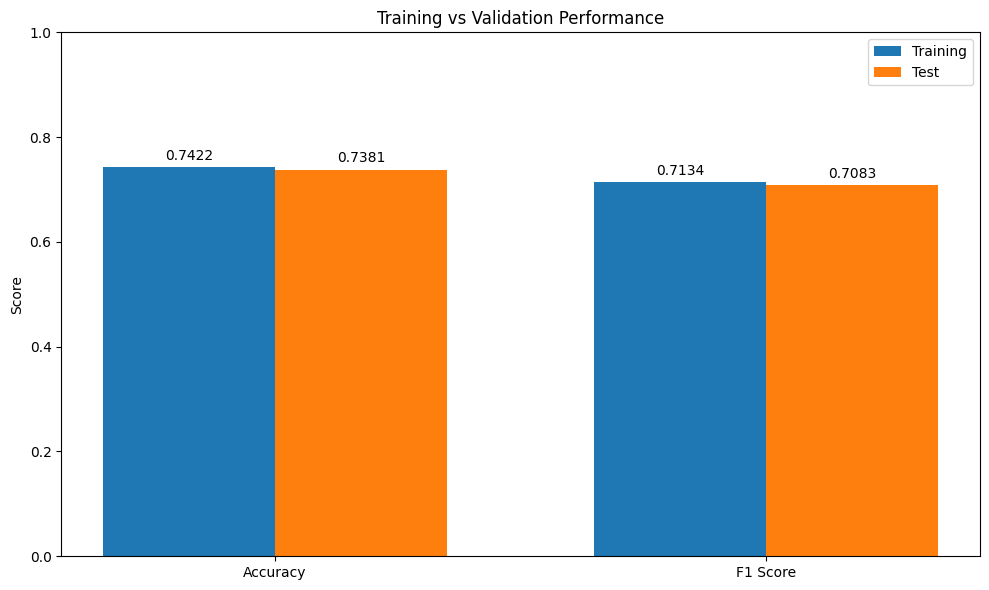

In [284]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [285]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.7381129271916791

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1599
           1       0.77      0.85      0.81      1877
           2       0.86      0.98      0.92       447
           3       0.34      0.30      0.32       250
           4       0.61      0.14      0.22        81
           5       0.79      0.78      0.78       766
           6       0.42      0.02      0.03       299
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        16

    accuracy                           0.74      5384
   macro avg       0.50      0.43      0.42      5384
weighted avg       0.71      0.74      0.71      5384



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


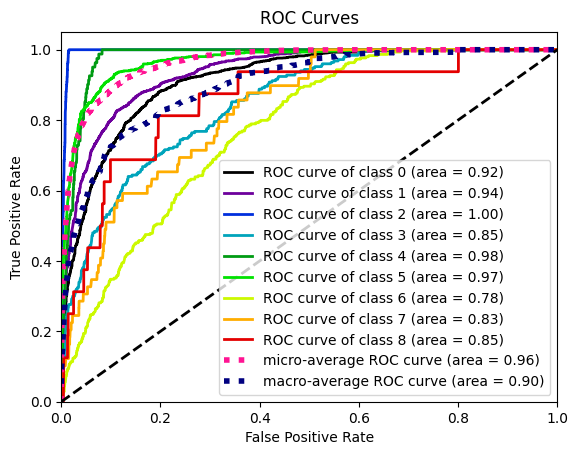

In [286]:
y_test_pred_proba = clf.predict_proba(X_test_tr)
# plot_roc(y_test, y_test_pred_proba)
# plt.show()

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_test_pred_proba)
plt.show()

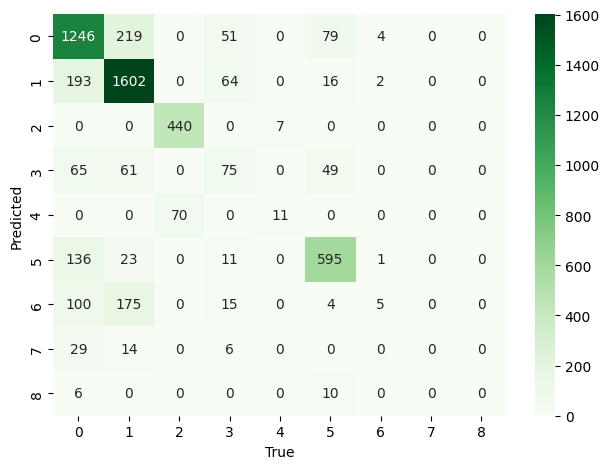

In [287]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

#### devo cambiare qualcosa?
Compare the results with a dummy classifier 

In [288]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3486255572065379
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1599
           1       0.35      1.00      0.52      1877
           2       0.00      0.00      0.00       447
           3       0.00      0.00      0.00       250
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00       766
           6       0.00      0.00      0.00       299
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        16

    accuracy                           0.35      5384
   macro avg       0.04      0.11      0.06      5384
weighted avg       0.12      0.35      0.18      5384



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
